Gravitational instability
===

The equations that gouvern the distribution of matter in the Universe are given by Newtons law for gravity. We assume gravity is the sole force responsible for forming strunctures in the Universe and that relativistic effects play a minor role. Moreover we will assume that this process is dominated by _dark matter_. The Newtonian field equation for gravity is the Poisson equation

$$\nabla^2 \Phi = 4 \pi G \rho.$$

However, in an expanding Universe this equation changes slightly to

$$\frac{1}{a^2} \nabla^2 \phi = 4 \pi G \rho_u \delta.$$

Here $a$ is the Hubble expansion factor, $\delta$ the density perturbation

$$\delta + 1 = \frac{\rho}{\rho_u},$$

and $\phi$ is the potential perturbation. Similarly the Euler equation describing Newton's second law can be written in Lagrangian form as

$$\partial_t(a \vec{v}) \big|_{q={\rm cst}} = -\nabla \phi.$$

Defining $v$ as the comoving velocity $v := a\dot{x}$. We have two sets of coordinates $q$ and $x$. $q$ being a label on a particle, telling it where it started at time $t = 0$.
Then

$$x = q + \int \frac{v}{a} {\rm d t}.$$

We define a momentum $p := a^2 \dot{x} = a v$, and rewrite the factor of proportionality

$$4 \pi G \rho_u = \frac{3H_0^2 \Omega_0}{2a^3},$$

so that the Poisson equation becomes

$$a\nabla^2 \phi = \frac{3}{2} \Omega_m H_0^2 \delta,$$

and the Euler equation

$$\dot{p} = - \nabla \phi.$$

To this we add the Friedman equation that describes the evolution of the expansion factor

$$\dot{a} = H_0 a \sqrt{\Omega_{\Lambda} + \Omega_{m} a^{-3} + (1 - \Omega) a^{-2}}.$$

Note that all time dependence in these equations is in the expansion factor $a(t)$, so we may express all time derivatives in terms of $a$.

$$\dot{x} = \frac{p}{a^2}\quad \to \quad \partial_a x = \frac{p}{a^2 \dot{a}}$$
$$\dot{p} = -\nabla \phi \quad \to \quad \partial_a p = - \frac{\nabla \phi}{\dot{a}}$$

This means we do not need to solve the Friedman equation explicitly. Rather we use $a$ as integration variable and use the Friedman equation to determine the relevant derivative $\dot{a}$.

Initial conditions
===

To make interesting initial conditions, I take a power spectrum of $P(k) = k^{-1/2}$ with a Gaussian smoothing.

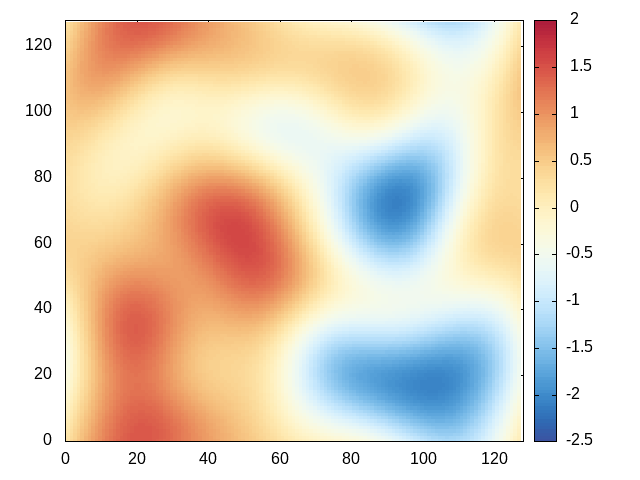

0.87064168302108125

In [14]:
import cft
import numpy as np
from numpy import fft, random
import gnuplot as gp
import os

N = 128
B_m = cft.Box(2, N, 50.0)
A = 40
seed = 6
Power_spectrum = cft.Power_law(0) * cft.Scale(B_m, 0.0) * cft.Cutoff(B_m)
phi = cft.garfield(B_m, Power_spectrum, cft.Potential(), seed) * A
rho = cft.garfield(B_m, Power_spectrum, cft.Scale(B_m, 5.0), seed) * A

gp.plot("set xrange [0:{0}] ; set yrange [0:{0}]".format(B_m.N),
        gp.plot_data(gp.array(rho.T, 'w image')))

rho.std()

Cosmology
===

The background cosmology is embodied by the Friedman equation

$$\dot{a} = H_0 a \sqrt{\Omega_{\Lambda} + \Omega_{m} a^{-3} + (1 - \Omega) a^{-2}}.$$

The class `Cosmology` is a function object returning the value of $\dot{a}$ as a function of $a$.
Later on we will need the _growing mode_ solution for this universe.

$$D(t) = H(t) \int_0^t \frac{{\rm d} t'}{a(t')^2 H(t')^2}$$

We'd like to do the integration in terms of $a$, substituting ${\rm d}t = {\rm d}a/\dot{a}$.

$$D(a) = \frac{\dot{a}}{a} \int_0^a \frac{{\rm d}a}{\dot{a}^3}$$

In [15]:
from scipy.integrate import quad

class Cosmology:
    """This object stores all relevant information wrt the background
    cosmology, parametrized by OmegaM, OmegaL and H0."""
    def __init__(self, H0, OmegaM, OmegaL):
        self.H0 = H0
        self.OmegaM = OmegaM
        self.OmegaL = OmegaL
        self.OmegaK = 1 - OmegaM - OmegaL
        self.grav_cst = 3./2 * OmegaM * H0**2
        self.factor = self._growing_mode_norm()

    def adot(self, a):
        return self.H0 * a * np.sqrt(self.OmegaL \
                + self.OmegaM * a**-3 \
                + self.OmegaK * a**-2)
    
    def _growing_mode_norm(self):
        """result D(1) = 1. d/d0 + 0.001 = 1"""
        d = self.adot(1) * quad(lambda b: self.adot(b)**(-3), 0.00001, 1)[0]
        return 0.99999/d

    def growing_mode(self, a):
        if isinstance(a, np.ndarray):
            return np.array([self.growing_mode(b) for b in a])
        elif a <= 0.001:
            return a
        else:
            return self.factor * self.adot(a)/a * quad(lambda b: self.adot(b)**(-3), 0.00001, a)[0] + 0.00001
    
    def __call__(self, a):
        return self.adot(a)

LCDM = Cosmology(68.0, 0.31, 0.69)
EdS = Cosmology(70.0, 1.0, 0.0)

This approach only works if the Universe keeps expanding.

Mass deposition
===

Proper mass depositions is somewhat of a dark art. The simplest scheme that is widely used goes by the name of _cloud-in-cell_.
A particle is seen as a clump of matter, the size of a pixel (the cloud). This matter is then divided over four neighbouring pixels by taking
the fractional position within the current pixel (the cell). This can be implemented using the NumPy `histogram2d` function with `weight`.

In [16]:
def md_cic(B, X):
    f  = X - np.floor(X)
    
    rho = np.zeros(B.shape, dtype='float64')
    rho_, x_, y_ = np.histogram2d(X[:,0]%B.N, X[:,1]%B.N, bins=B.shape, 
                        range=[[0, B.N], [0, B.N]], 
                        weights=(1 - f[:,0])*(1 - f[:,1]))
    rho += rho_
    rho_, x_, y_ = np.histogram2d((X[:,0]+1)%B.N, X[:,1]%B.N, bins=B.shape, 
                        range=[[0, B.N], [0, B.N]], 
                        weights=(f[:,0])*(1 - f[:,1]))
    rho += rho_
    rho_, x_, y_ = np.histogram2d(X[:,0]%B.N, (X[:,1]+1)%B.N, bins=B.shape, 
                        range=[[0, B.N], [0, B.N]], 
                        weights=(1 - f[:,0])*(f[:,1]))
    rho += rho_
    rho_, x_, y_ = np.histogram2d((X[:,0]+1)%B.N, (X[:,1]+1)%B.N, bins=B.shape, 
                        range=[[0, B.N], [0, B.N]], 
                        weights=(f[:,0])*(f[:,1]))
    rho += rho_
    
    return rho

Integators
===
As integrators go, the _leap-frog_ method is both simple and reasonably accurate. It has the nice property that the integration is reversible. In the lore of symplectic integrators this means that energy is conserved.

In [17]:
class Integrator:
    def run(self, a0, da, N):
        raise NotImplented

class LeapFrog(Integrator):
    def __init__(self, solver):
        self.solver = solver
        
    def run(self, a0, da, N):
        a = a0
        
        # the kick is half a step ahead
        S = self.solver(a, a + da/2)
        for i in range(N):
            S.drift(a, da)
            S.kick(a+da/2, da)
            a += da
            
        return S

In [18]:
class Interp2D:
    "Reasonably fast bilinear interpolation routine"
    def __init__(self, data):
        self.data = data
        self.shape = data.shape

    def __call__(self, x):
        X1 = np.floor(x).astype(int) % self.shape
        X2 = np.ceil(x).astype(int) % self.shape
        xm = x % 1.0
        xn = 1.0 - xm

        f1 = self.data[X1[:,0], X1[:,1]]
        f2 = self.data[X2[:,0], X1[:,1]]
        f3 = self.data[X1[:,0], X2[:,1]]
        f4 = self.data[X2[:,0], X2[:,1]]

        return  f1 * xn[:,0] * xn[:,1] + \
                f2 * xm[:,0] * xn[:,1] + \
                f3 * xn[:,0] * xm[:,1] + \
                f4 * xm[:,0] * xm[:,1]

def gradient_2nd_order(F, i):
	return   1./12 * np.roll(F,  2, axis=i) - 2./3  * np.roll(F,  1, axis=i) \
			+ 2./3  * np.roll(F, -1, axis=i) - 1./12 * np.roll(F, -2, axis=i)

Gravity
===

Gravity is a three-dimensional phenomenon. We take a leap of faith that we may use the same equations in 2D and the results will be similar to a slice from a 3D simulation. To do this properly, we would need to proof that this is identical to simulating an inifinite stack of copies of the 2D universe. The force should go as $1/r$ and the corresponding potential as $\log(r)$.

The previously described Leap-frog integrator needs a solver class to provide it with a _drift_ and _kick_ operator. The drift is simply translating the particles by the appropriate amount following $\partial_a x = p/(a^2 \dot{a})$. The kick is a bit more complicated. It needs to find the gravitational potential that each particle feels to get the proper acceleration. To this end we first compute $\delta$, by using the CIC mass deposition. Then we use Fourier space to compute the appropriate potential. The gradient of this potential is evaluated in real space using a second order scheme, and linear interpolation to get approximate values at the particle positions.

In [19]:
def a2r(B, X):
    return X.transpose([1,2,0]).reshape([B.N**2, 2])

def r2a(B, x):
    return x.reshape([B.N, B.N, 2]).transpose([2,0,1])

class Solver:
    def __init__(self, B, m, C, X, P):
        self.B = B
        self.C = C
        self.X = X
        self.P = P
        self.m = m
        
        self.g = gp.Gnuplot(persist=True)
        self.g("set cbrange [0.2:50]", "set log cb", "set size square",
               "set xrange [0:{0}] ; set yrange [0:{0}]".format(B.N))
        
    def drift(self, a, da):
        adot = self.C(a)
        self.X += da * self.P / (a**2 * adot)
        
    def kick(self, a, da):
        adot  = self.C(a)
        x = self.X/self.B.res
        delta = md_cic(self.B, x) * self.m - 1.0
        self.g(gp.plot_data(gp.array(delta.T+1, "t'' w image")))
        fn = 'data/x.{0:05d}.npy'.format(int(round(a*1000)))
        np.save(fn, self.X)
        
        phi   = fft.ifftn(fft.fftn(delta) * cft.Potential()(self.B.K)).real * self.C.grav_cst / a
        
        acc_x = Interp2D(gradient_2nd_order(phi, 0))
        acc_y = Interp2D(gradient_2nd_order(phi, 1))
        acc = np.c_[acc_x(x), acc_y(x)] / self.B.res
        
        self.P -= da * acc / adot

To create good initial conditions from the initial potential we have to use Zeldovich approximation. At the same time we may use this class as a factory for setting up the rest of the simulation; this means providing the solver with proper box sizes and cosmology. The Leap-frog integrator needs the velocity at a different time than the particle positions (half a time-step difference). So the `Zeldovich` class provides functionality to do just that. In the particle velocity there's no difference, but the momentum does factor in the expansion factor.

The `Zeldovich` class takes two box arguments. One is the _mass box_, the other the _force box_. To prevent aliasing in the voids it is important to have the force box twice the size of the mass box.

In [20]:
class Zeldovich:
    def __init__(self, B_mass, B_force, C, phi):
        self.bm = B_mass
        self.bf = B_force
        self.C  = C
        
        self.u = np.array([-gradient_2nd_order(phi, 0), 
                           -gradient_2nd_order(phi, 1)]) / self.bm.res
        
    def __call__(self, a_pos, a_vel = None):
        if a_vel == None: 
            a_vel = a_pos
        
        X = a2r(self.bm, np.indices(self.bm.shape) * self.bm.res + a_pos * self.u)
        P = a2r(self.bm, a_vel * self.u)
        
        # particle mass
        m = (self.bf.N / self.bm.N)**self.bm.dim
        
        return Solver(self.bf, m, self.C, X, P)

Running the code
====

In [21]:
import gnuplot as gp
za = Zeldovich(B_m, cft.Box(2, N*2, B_m.L), EdS, phi)
S = LeapFrog(za).run(0.02, 0.02, 50)